# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

labels:  (73257,) images:  (32, 32, 3, 73257)
Label: 9


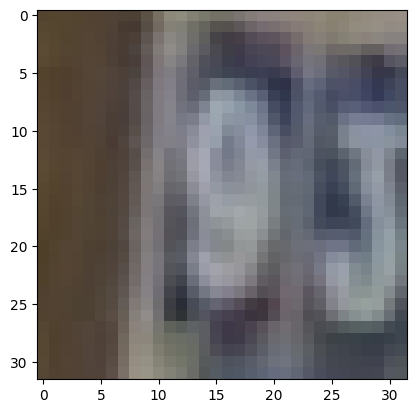

In [2]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,6], labels[6] 
print("labels: ", labels.shape, "images: ", images.shape)
print('Label: ' + str(example_label))
plt.imshow(example_image)

# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

# Sol. 1

In [3]:
#Making native class loader
import PIL.Image as Image

class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


## Base CNN

In [4]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class BaseConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(BaseConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2).cuda()
        #input : 3 channel, output 16 channel, filter size : 5x5 and padding 2
        # the ouput of this channel will be 16x32x32 (assuming our image is in fact 32x32) since the pixels
        # that the convolution operation collapses into are 32x32 (the padding is 2 so the image is not reduced)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1).cuda()
        #input : 16 channel, output 32 channel, filter size : 3x3
        # simmilary the output of this channel will be 32x32x32. If the kernel is 3x3, then the dimensions are reduced by
        # 2 (since the padding is 1) in both height and width, but the padding counters this.
        
        self.fc = nn.Linear(8*8*32, num_classes).cuda
        # must match the previous dimensions in the input. In the case of the SVHM dataset, the input is 32x32x3, and after
        # doing 2 convolutions that do not reduce the height and width, but 2 maxpooling operations after the convolutions, the
        # dimensions are 8x8x32, since the final channel number is 32. The 8*8*32 is the number of pixels in the image after the 
        # convolutions, and the number of channels
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [4]:
from torch.optim import lr_scheduler as lrs

In [6]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    scheduler = lrs.ExponentialLR(optimizer, gamma=0.9)
    total_step = len(train_loader)
    losses_list = []
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            losses_list.append(loss.item())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        scheduler.step()
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [7]:
BaseCNN = BaseConvNet()
# CNN = CNN.cuda()
import torchvision.transforms as tf

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

In [7]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader, optimizer, num_epochs, model_name='base_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))
# Create test data loader


NameError: name 'BaseCNN' is not defined

# Refined CNN's

We will not create a CNN class for each hyperparameter configuration. Instead, we will change the RefinedConvNet class

In [5]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

## More Layers LONG

In [9]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class LongConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(LongConvNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=5,  padding=2).cuda() 
        
    
        self.conv12 = nn.Conv2d(16, 16, kernel_size=5, padding=2).cuda()
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1).cuda()

        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1).cuda()
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 3x3x64
        
        self.fc = nn.Linear(4*4*64, num_classes).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        # self.batchnorm = nn.BatchNorm2d(16).cuda()
        self.batchnorm2 = nn.BatchNorm2d(16).cuda()
        self.batchnorm3 = nn.BatchNorm2d(32).cuda()
# 
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.batchnorm2(self.relu(self.conv12(out11))) + out11
        out = self.maxpool(out12)
        

        out21 = self.relu(self.conv21(out))
        out22 = self.batchnorm3(self.relu(self.conv22(out21))) + out21
        out = self.maxpool(out22)

        out31 = self.relu(self.conv31(out))
        out32 = self.relu(self.conv32(out31)) + out31
        out = self.maxpool(out32)
        
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

model = LongConvNet(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 87290


## proposed ResNet

In [45]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class Proposal(nn.Module):
    def __init__(self, num_classes=10):
        
        super(Proposal, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3,  padding=1).cuda() 
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1).cuda()
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1).cuda()
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        self.conv23 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1).cuda()
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 4x4x64
        
        self.fc = nn.Linear(4*4*64, num_classes,).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.avgpool= nn.AvgPool2d(kernel_size=2, stride=2).cuda()

        self.relu = nn.ReLU().cuda()
        self.bn11 = nn.BatchNorm2d(16).cuda()
        self.bn12 = nn.BatchNorm2d(16).cuda()
        self.bn13 = nn.BatchNorm2d(16).cuda()

        self.bn21 = nn.BatchNorm2d(32).cuda()
        self.bn22 = nn.BatchNorm2d(32).cuda()
        self.bn23 = nn.BatchNorm2d(32).cuda()

        self.bn31 = nn.BatchNorm2d(64).cuda()
        self.bn32 = nn.BatchNorm2d(64).cuda()
        self.bn33 = nn.BatchNorm2d(64).cuda()
        # self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

# 
        
    def forward(self, x):
        
        out11 = self.conv11(x)
        out12 = self.relu(self.bn11(out11)) #preactivation
        out12 = self.conv12(out12) #convolution
        out13 = self.conv13(self.relu(self.bn12(out12))) #residual connection
        out   = out11 + out13 #skip connection
        out   = self.relu(self.bn13(out)) #postactivation
        out   = self.maxpool(out)

        out21 = self.conv21(out)
        out22 = self.conv22(self.relu(self.bn21(out21))) #preactivation and convolution
        out23 = self.conv23(self.relu(self.bn22(out22))) #residual connections
        out   = out21 + out23 #skip connection
        out   = self.relu(self.bn23(out)) #postactivation
        out   = self.maxpool(out)

        out31 = self.conv31(out)
        out32 = self.conv32(self.relu(self.bn31(out31))) #preactivation and convolution
        out33 = self.conv33(self.relu(self.bn32(out32))) #residual connections
        out   = out31 + out33 #skip connection
        out   = self.relu(self.bn33(out)) #postactivation
        out   = self.avgpool(out)
       
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        # out = self.logsoftmax(out)
        return out 

model = Proposal(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 131498


In [19]:
LongCNN = LongConvNet()
optimizer = torch.optim.Adam(LongCNN.parameters(),lr = learning_rate)

loss_hist = train(LongCNN, train_loader, optimizer, num_epochs, model_name='long_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(LongCNN, test_loader)))
# Create test data loader

NameError: name 'learning_rate' is not defined

## Different Optimizers

In [8]:
MomCNN = BaseConvNet()
optimizer_mom = optim.SGD(MomCNN.parameters(), lr=0.01, momentum=0.9)

loss_hist = train(MomCNN, train_loader, optimizer, num_epochs, model_name='mom_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(MomCNN, test_loader)))
# Create test data loader

NameError: name 'optim' is not defined

In [ ]:
AdamCNN = BaseConvNet()
optimizer_adadelta = torch.optim.Adadelta(AdamCNN.parameters(),lr = 0.001)

loss_hist = train(AdamCNN, train_loader, optimizer, num_epochs, model_name='adam_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(AdamCNN, test_loader)))
# Create test data loader

# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [7]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [49]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


# My MODEL

In [18]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,  padding=1).cuda()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,  padding=1).cuda()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,  padding=1).cuda()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3,  padding=1).cuda()

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3,  padding=1).cuda()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3,  padding=1).cuda()
        
        self.fc1 = nn.Linear(4*4*128, 128).cuda()
        self.fc2 = nn.Linear(128, num_classes).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        self.soft_max = nn.Softmax(dim=1).cuda()

        self.drop_out3 = nn.Dropout(p=0.3).cuda()
        self.drop_out4 = nn.Dropout(p=0.4).cuda()
        self.batch_norm1 = nn.BatchNorm2d(32).cuda()
        self.batch_norm2 = nn.BatchNorm2d(32).cuda()
        self.batch_norm3 = nn.BatchNorm2d(64).cuda()

    def forward(self, x):
# conv, bat, conv, max, drop, conv, bat, conv, max, drop, conv, bat, conv, max, drop, flat, dense, drop, dense
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.batch_norm3(out)
        
        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)

        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop_out3(out)

        out = self.fc2(out)
        out = self.soft_max(out)
        return out 





model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))

MyModel Parameters: 550826


# Inception 

In [19]:
class IncSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(IncSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=1, stride=2, padding=0)
        self.conv12 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv13 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        
        self.conv21 = nn.Conv2d(192, 128, kernel_size=1, stride=2, padding=0)
        self.conv22 = nn.Conv2d(192, 128, kernel_size=3, stride=2, padding=1)
        self.conv23 = nn.Conv2d(192, 128, kernel_size=5, stride=2, padding=2)
        
        self.fc = nn.Linear(8*8*384, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        #Inc 1 
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(x))
        out13 = self.relu(self.conv13(x))
        
        out1a = [out11, out12, out13]
        out1a = torch.cat(out1a,dim=1)
        
        #Inc 12
        out21 = self.relu(self.conv21(out1a))
        out22 = self.relu(self.conv22(out1a))
        out23 = self.relu(self.conv23(out1a))
        
        out2a = [out21, out22, out23]
        out2a = torch.cat(out2a,1)
        
        out = out2a.view(out2a.size(0), -1)
        out = self.fc(out)
        
        return out
model = IncSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 1113226
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


## Sol. 2

In [1]:
!cd ""

c:\Users\alber\OneDrive - estudiant.upf.edu\UNI (upf)\3rd yaaaaar\DeepLearning\DeepLearning\P3


### Define your own model and check the number of total parameters

In [3]:
32/8

4.0

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)


        self.fc= nn.Linear(2*2*32, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2) # 16x16
        self.relu = nn.ReLU()

                

                
    def forward(self, x): 
        out = self.relu(self.conv1(x))
        out = self.maxpool(out)
        out = self.maxpool(out)
        out = self.maxpool(out)
        out = self.maxpool(out)
        #Reshape
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

        


model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))



MyModel Parameters: 2186


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.fc1= nn.Linear(2*2*128, 128)
        self.fc2= nn.Linear(128, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2) # 16x16
        self.relu = nn.ReLU()

                

                
    def forward(self, x): 
        out = self.relu(self.conv1(x))
        out = self.maxpool(out)
        out = self.relu(self.conv2(out))
        out = self.maxpool(out)
        out = self.relu(self.conv3(out))
        out = self.maxpool(out)
        #Reshape
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out        


model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))



MyModel Parameters: 160202


### FINAL MODEL EQUISDE

In [17]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class Equisde(nn.Module):
    def __init__(self, num_classes=10):
        
        super(Equisde, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3,  padding=1) 
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv15 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv23 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 4x4x64
        
        self.fc = nn.Linear(4*4*64, num_classes,)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool= nn.AvgPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()
        self.bn11 = nn.BatchNorm2d(16)
        self.bn12 = nn.BatchNorm2d(16)
        self.bn13 = nn.BatchNorm2d(16)
        self.bn14 = nn.BatchNorm2d(16)
        self.bn15 = nn.BatchNorm2d(16)
        

        self.bn21 = nn.BatchNorm2d(32)
        self.bn22 = nn.BatchNorm2d(32)
        self.bn23 = nn.BatchNorm2d(32)

        self.bn31 = nn.BatchNorm2d(64)
        self.bn32 = nn.BatchNorm2d(64)
        self.bn33 = nn.BatchNorm2d(64)
        # self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

# 
        
    def forward(self, x):
        
        out11 = self.conv11(x)
        out12 = self.conv12(self.relu(self.bn11(out11)))        
        out13 = self.conv13(self.relu(self.bn12(out12))) #residual connection
        out   = out11 + out13 #skip connection
        out14   =  self.conv14(self.relu(self.bn13(out))) #postactivation
        out15   =  self.conv15(self.relu(self.bn14(out14))) #postactivation
        out     = out + out15 #skip connection
        out     = self.relu(self.bn15(out)) #postactivation
        out     = self.maxpool(out)

        out21 = self.conv21(out)
        out22 = self.conv22(self.relu(self.bn21(out21))) #preactivation and convolution
        out23 = self.conv23(self.relu(self.bn22(out22))) #residual connections
        out   = out21 + out23 #skip connection
        out   = self.relu(self.bn23(out)) #postactivation
        out   = self.maxpool(out)

        out31 = self.conv31(out)
        out32 = self.conv32(self.relu(self.bn31(out31))) #preactivation and convolution
        out33 = self.conv33(self.relu(self.bn32(out32))) #residual connections
        out   = out31 + out33 #skip connection
        out   = self.relu(self.bn33(out)) #postactivation
        out   = self.avgpool(out)
       
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        # out = self.logsoftmax(out)
        return out 

model = Equisde(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 136202


### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [8]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio

import numpy as np



data_path = 'Data'
results_path = 'Results'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [48]:
# Train function
import torch.optim.lr_scheduler as lrs
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', scheduler=None,criterion=nn.CrossEntropyLoss()):
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            
            loss = criterion(outputs, labels)
            
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [11]:
def get_batch_hard(CNN, train_loader, prop=0.7, device='cpu'):
    with torch.no_grad():
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            # get loss
            loss = criterion(outputs, labels)
            losses.append(loss)
        losses = torch.stack(losses)
        losses = losses.cpu().numpy()
        idx = np.argsort(losses)[::-1]
        idx_hard_batches = idx[:int(len(train_loader)*prop)]
        return idx_hard_batches
    
def train_hard(CNN, train_loader, optimizer, num_epochs=5, prop=0.7, model_name='model.ckpt', device='cpu', scheduler=None):

# get the batches to run through the model
    idx_hard = get_batch_hard(CNN, train_loader, prop=prop, device=device)
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            if i not in idx_hard: continue
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

In [9]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [13]:
max_degree = 8
tr_model = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomRotation(max_degree),
        tf.RandomAffine(degrees=0, translate=(0, 0.1), scale=(0.95, 1.05), shear=0.15)
        ])

In [14]:
max_degree = 10

SVHNTrain_gray = SVHN(data_path+'/svhn/train_32x32.mat',tr_model)
SVHNTest_gray = SVHN(data_path+'/svhn/test_32x32.mat',tr_model)

train_loader_gray = torch.utils.data.DataLoader(dataset=SVHNTrain_gray,
                                               batch_size=256, 
                                               shuffle=True)

test_loader_gray = torch.utils.data.DataLoader(dataset=SVHNTest_gray,
                                               batch_size=256, 
                                               shuffle=True)

TRain the model

In [46]:
#Train MyModel
my_model = Proposal(num_classes=10)

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)

print('number of parameters: ' + str(compute_model_params(my_model)))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='Prop_wo_postact.ckpt', device=device,criterion=nn.CrossEntropyLoss())

number of parameters: 131498
Epoch [1/10], Step [100/287], Loss: 1.2986
Epoch [1/10], Step [200/287], Loss: 0.8724
Epoch [1/10], Step [287/287], Loss: 0.7175
Epoch [2/10], Step [100/287], Loss: 0.2876
Epoch [2/10], Step [200/287], Loss: 0.2848
Epoch [2/10], Step [287/287], Loss: 0.2796
Epoch [3/10], Step [100/287], Loss: 0.2193
Epoch [3/10], Step [200/287], Loss: 0.2241
Epoch [3/10], Step [287/287], Loss: 0.2232
Epoch [4/10], Step [100/287], Loss: 0.1817
Epoch [4/10], Step [200/287], Loss: 0.1893
Epoch [4/10], Step [287/287], Loss: 0.1912
Epoch [5/10], Step [100/287], Loss: 0.1630
Epoch [5/10], Step [200/287], Loss: 0.1643
Epoch [5/10], Step [287/287], Loss: 0.1655
Epoch [6/10], Step [100/287], Loss: 0.1310
Epoch [6/10], Step [200/287], Loss: 0.1427
Epoch [6/10], Step [287/287], Loss: 0.1465
Epoch [7/10], Step [100/287], Loss: 0.1227
Epoch [7/10], Step [200/287], Loss: 0.1259
Epoch [7/10], Step [287/287], Loss: 0.1291
Epoch [8/10], Step [100/287], Loss: 0.1093
Epoch [8/10], Step [200/2

In [ ]:
losses_list = train_hard(my_model, train_loader, optimizer, num_epochs=10, model_name='Prop_wo_postact.ckpt', device=device, scheduler="pepesito")
plt.plot(losses_list)
plt.show()

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [47]:
# Show results for all the trained models
data_path = 'Data'
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = Proposal()
my_net.load_state_dict(torch.load(results_path + '/Prop_wo_postact.ckpt'))
my_net.to(device)
acc = test(my_net, test_loader) 

print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 93.73463429625077


# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [94]:
max_degree = 10
tr = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomCrop(32, padding=4),
        tf.RandomRotation(max_degree)
        ])

# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [95]:
#Train ResNet
base_model = Proposal(num_classes=8)

learning_rate = .001
optimizer = torch.optim.Adam(base_model.parameters(),lr = learning_rate, weight_decay=1e-5)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

losses_base = train(base_model, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device,criterion=nn.CrossEntropyLoss())

Epoch [1/10], Step [100/249], Loss: 1.3509
Epoch [1/10], Step [200/249], Loss: 1.0077
Epoch [1/10], Step [249/249], Loss: 0.9161
Epoch [2/10], Step [100/249], Loss: 0.4665
Epoch [2/10], Step [200/249], Loss: 0.4420
Epoch [2/10], Step [249/249], Loss: 0.4292
Epoch [3/10], Step [100/249], Loss: 0.3635
Epoch [3/10], Step [200/249], Loss: 0.3550
Epoch [3/10], Step [249/249], Loss: 0.3490
Epoch [4/10], Step [100/249], Loss: 0.3129
Epoch [4/10], Step [200/249], Loss: 0.3073
Epoch [4/10], Step [249/249], Loss: 0.3054
Epoch [5/10], Step [100/249], Loss: 0.2815
Epoch [5/10], Step [200/249], Loss: 0.2818
Epoch [5/10], Step [249/249], Loss: 0.2807
Epoch [6/10], Step [100/249], Loss: 0.2607
Epoch [6/10], Step [200/249], Loss: 0.2634
Epoch [6/10], Step [249/249], Loss: 0.2627
Epoch [7/10], Step [100/249], Loss: 0.2460
Epoch [7/10], Step [200/249], Loss: 0.2467
Epoch [7/10], Step [249/249], Loss: 0.2475
Epoch [8/10], Step [100/249], Loss: 0.2332
Epoch [8/10], Step [200/249], Loss: 0.2332
Epoch [8/10

In [106]:
import time
print(np.arange(0,11,1))

fine_tuned_model = Proposal(num_classes=8)
fine_tuned_model.load_state_dict(torch.load(results_path + '/tl_mynet_svhn.ckpt'))
fine_tuned_model = fine_tuned_model.to(device)
fine_tuned_model.fc = nn.Linear(4*4*64, 2).cuda()

# freeze layers
for idx, param in enumerate(fine_tuned_model.parameters()):
    type_param = ''
    ???
    print(idx, param.requires_grad, type_param)


    

[ 0  1  2  3  4  5  6  7  8  9 10]
0 True other
1 True other
2 True other
3 True other
4 True other
5 True other
6 True other
7 True other
8 True other
9 True other
10 True other
11 True other
12 True other
13 True other
14 True other
15 True other
16 True other
17 True other
18 True other
19 True other
20 True other
21 True other
22 True other
23 True other
24 True other
25 True other
26 True other
27 True other
28 True other
29 True other
30 True other
31 True other
32 True other
33 True other


Epoch [1/10], Step [4/4], Loss: 0.6856
Epoch [2/10], Step [4/4], Loss: 0.3976
Epoch [3/10], Step [4/4], Loss: 0.2926
Epoch [4/10], Step [4/4], Loss: 0.2029
Epoch [5/10], Step [4/4], Loss: 0.1822
Epoch [6/10], Step [4/4], Loss: 0.1770
Epoch [7/10], Step [4/4], Loss: 0.0974
Epoch [8/10], Step [4/4], Loss: 0.1200
Epoch [9/10], Step [4/4], Loss: 0.1226
Epoch [10/10], Step [4/4], Loss: 0.0676


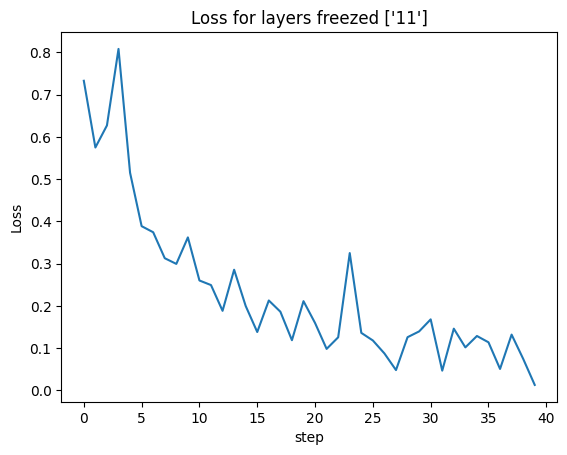

Accuracy ResNet Transfer Learning with layers freezed ['11']: 93.18592537472095 

Epoch [1/10], Step [4/4], Loss: 0.5848
Epoch [2/10], Step [4/4], Loss: 0.3596
Epoch [3/10], Step [4/4], Loss: 0.2244
Epoch [4/10], Step [4/4], Loss: 0.1900
Epoch [5/10], Step [4/4], Loss: 0.1309
Epoch [6/10], Step [4/4], Loss: 0.1112
Epoch [7/10], Step [4/4], Loss: 0.0962
Epoch [8/10], Step [4/4], Loss: 0.1123
Epoch [9/10], Step [4/4], Loss: 0.0984
Epoch [10/10], Step [4/4], Loss: 0.0641


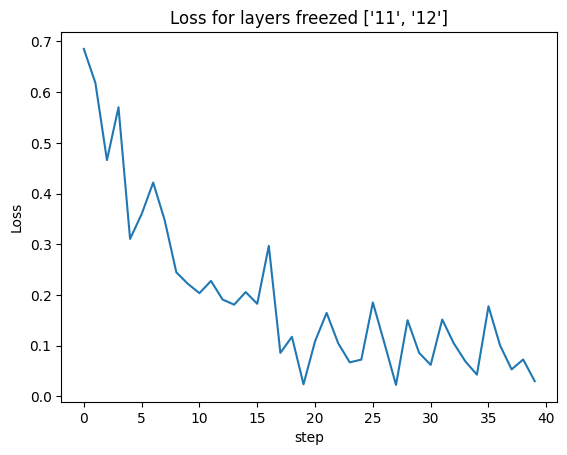

Accuracy ResNet Transfer Learning with layers freezed ['11', '12']: 93.58987987668758 

Epoch [1/10], Step [4/4], Loss: 0.5101
Epoch [2/10], Step [4/4], Loss: 0.2828
Epoch [3/10], Step [4/4], Loss: 0.1783
Epoch [4/10], Step [4/4], Loss: 0.1275
Epoch [5/10], Step [4/4], Loss: 0.1048
Epoch [6/10], Step [4/4], Loss: 0.1013
Epoch [7/10], Step [4/4], Loss: 0.0686
Epoch [8/10], Step [4/4], Loss: 0.1074
Epoch [9/10], Step [4/4], Loss: 0.0777
Epoch [10/10], Step [4/4], Loss: 0.0532


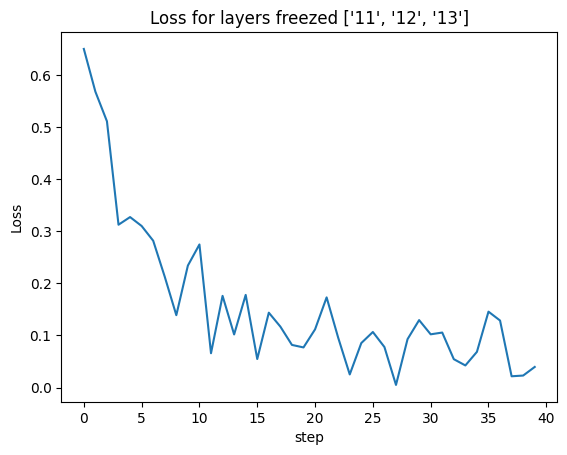

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13']: 94.1851812480068 

Epoch [1/10], Step [4/4], Loss: 0.5521
Epoch [2/10], Step [4/4], Loss: 0.3071
Epoch [3/10], Step [4/4], Loss: 0.2199
Epoch [4/10], Step [4/4], Loss: 0.1801
Epoch [5/10], Step [4/4], Loss: 0.1481
Epoch [6/10], Step [4/4], Loss: 0.1166
Epoch [7/10], Step [4/4], Loss: 0.0769
Epoch [8/10], Step [4/4], Loss: 0.0860
Epoch [9/10], Step [4/4], Loss: 0.1054
Epoch [10/10], Step [4/4], Loss: 0.0481


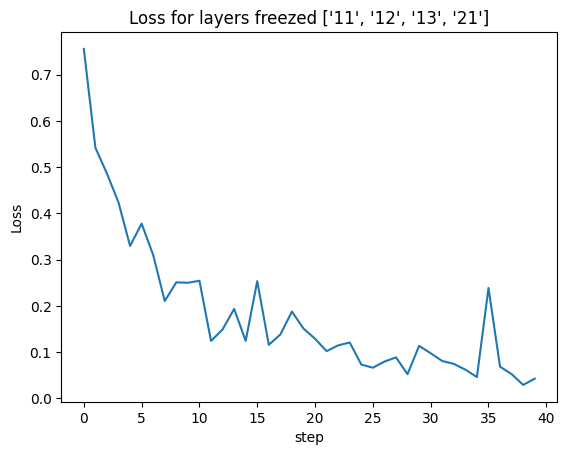

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21']: 93.19655575635166 

Epoch [1/10], Step [4/4], Loss: 0.5656
Epoch [2/10], Step [4/4], Loss: 0.3251
Epoch [3/10], Step [4/4], Loss: 0.2142
Epoch [4/10], Step [4/4], Loss: 0.1529
Epoch [5/10], Step [4/4], Loss: 0.1311
Epoch [6/10], Step [4/4], Loss: 0.1142
Epoch [7/10], Step [4/4], Loss: 0.2238
Epoch [8/10], Step [4/4], Loss: 0.0745
Epoch [9/10], Step [4/4], Loss: 0.1046
Epoch [10/10], Step [4/4], Loss: 0.0692


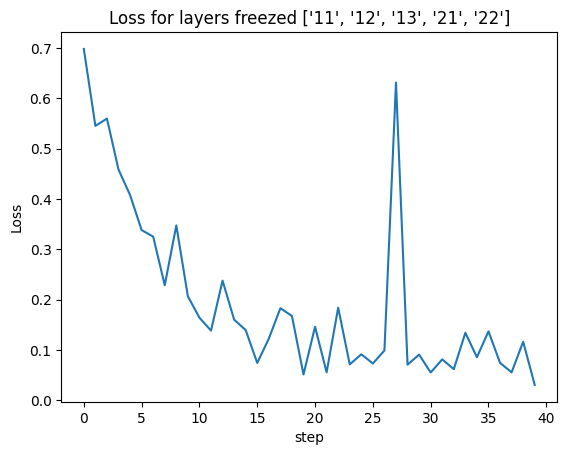

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21', '22']: 91.00669714042733 

Epoch [1/10], Step [4/4], Loss: 0.6788
Epoch [2/10], Step [4/4], Loss: 0.3779
Epoch [3/10], Step [4/4], Loss: 0.2342
Epoch [4/10], Step [4/4], Loss: 0.2957
Epoch [5/10], Step [4/4], Loss: 0.1649
Epoch [6/10], Step [4/4], Loss: 0.1305
Epoch [7/10], Step [4/4], Loss: 0.0953
Epoch [8/10], Step [4/4], Loss: 0.0749
Epoch [9/10], Step [4/4], Loss: 0.1205
Epoch [10/10], Step [4/4], Loss: 0.0501


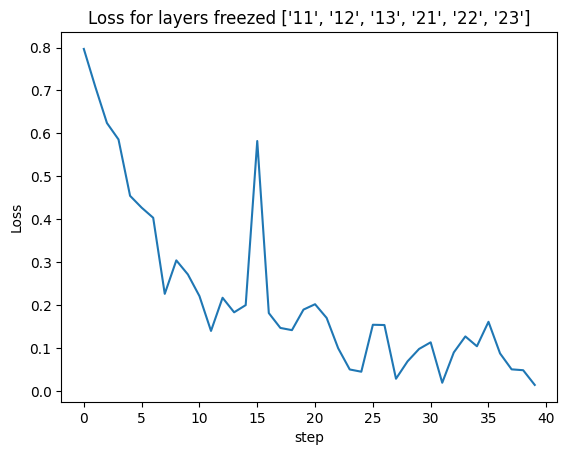

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21', '22', '23']: 93.32412033592006 

Epoch [1/10], Step [4/4], Loss: 0.6380
Epoch [2/10], Step [4/4], Loss: 0.4266
Epoch [3/10], Step [4/4], Loss: 0.3174
Epoch [4/10], Step [4/4], Loss: 0.2251
Epoch [5/10], Step [4/4], Loss: 0.2138
Epoch [6/10], Step [4/4], Loss: 0.1541
Epoch [7/10], Step [4/4], Loss: 0.1039
Epoch [8/10], Step [4/4], Loss: 0.2162
Epoch [9/10], Step [4/4], Loss: 0.0828
Epoch [10/10], Step [4/4], Loss: 0.1195


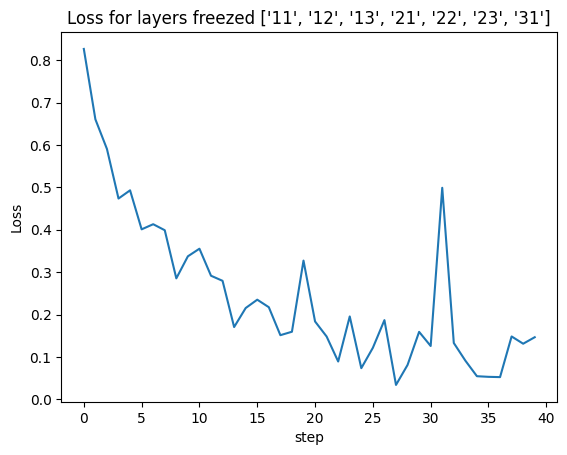

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21', '22', '23', '31']: 93.02646965026044 

Epoch [1/10], Step [4/4], Loss: 0.5764
Epoch [2/10], Step [4/4], Loss: 0.3676
Epoch [3/10], Step [4/4], Loss: 0.3165
Epoch [4/10], Step [4/4], Loss: 0.2135
Epoch [5/10], Step [4/4], Loss: 0.1328
Epoch [6/10], Step [4/4], Loss: 0.1212
Epoch [7/10], Step [4/4], Loss: 0.0864
Epoch [8/10], Step [4/4], Loss: 0.1338
Epoch [9/10], Step [4/4], Loss: 0.0886
Epoch [10/10], Step [4/4], Loss: 0.0781


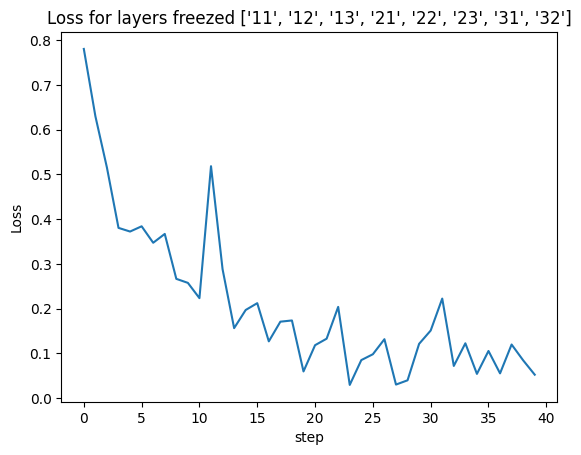

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21', '22', '23', '31', '32']: 93.17529499309025 

Epoch [1/10], Step [4/4], Loss: 0.7386
Epoch [2/10], Step [4/4], Loss: 0.4800
Epoch [3/10], Step [4/4], Loss: 0.3512
Epoch [4/10], Step [4/4], Loss: 0.1968
Epoch [5/10], Step [4/4], Loss: 0.2446
Epoch [6/10], Step [4/4], Loss: 0.1255
Epoch [7/10], Step [4/4], Loss: 0.1056
Epoch [8/10], Step [4/4], Loss: 0.1159
Epoch [9/10], Step [4/4], Loss: 0.0935
Epoch [10/10], Step [4/4], Loss: 0.0884


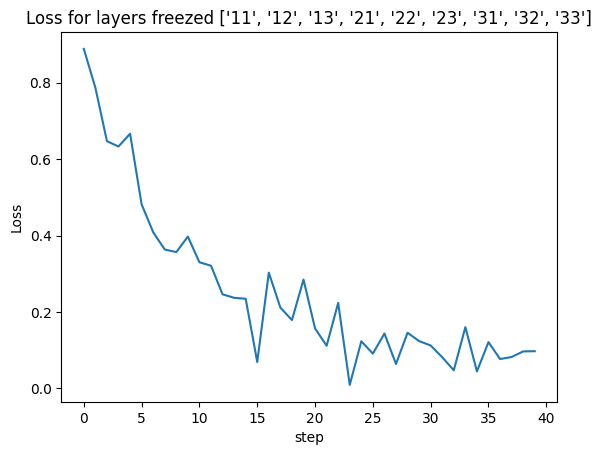

Accuracy ResNet Transfer Learning with layers freezed ['11', '12', '13', '21', '22', '23', '31', '32', '33']: 92.53747209524822 



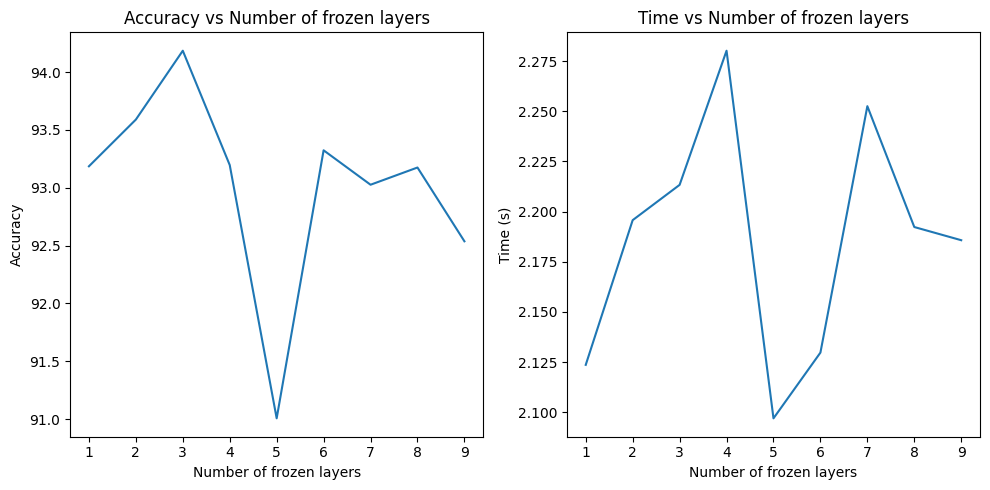

In [115]:
criterion = nn.CrossEntropyLoss()
model = Proposal(num_classes=8)
layers = ['11', '12', '13', '21', '22', '23', '31', '32', '33', 'fc']
arr_acc = []
arr_time = []
layers_to_freeze = list(range(1,len(layers)))
for num_freeze in layers_to_freeze:
    # copy the pretrained model
    fine_tuned_model = Proposal(num_classes=8)
    fine_tuned_model.load_state_dict(torch.load(results_path + '/tl_mynet_svhn.ckpt'))
    fine_tuned_model = fine_tuned_model.to(device)
    fine_tuned_model.fc = nn.Linear(4*4*64, 2).cuda()
    
    # freeze layers
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers[:num_freeze]):
            param.requires_grad = False
    # get the optimizer
    learning_rate = .0005
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()),lr = learning_rate,
                                 weight_decay=1e-5)
    
    start_time = time.time()
    losses_freeze = train(fine_tuned_model, tl_train_loader_0_9, optimizer, num_epochs=10, model_name=f'tl_mynet_svhn_{num_freeze}.ckpt', device=device,criterion=criterion)
    end_time = time.time()
    arr_time.append(end_time - start_time)
    plt.plot(losses_freeze)
    plt.title("Loss for layers freezed "+str(layers[:num_freeze]))
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.show()
    acc = test(fine_tuned_model, tl_test_loader_0_9)
    arr_acc.append(acc)
    print('Accuracy ResNet Transfer Learning with layers freezed '+str(layers[:num_freeze])+': ' + str(acc),"\n")


In [ ]:

fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(layers_to_freeze,arr_acc)
axs[0].set_xlabel('Number of frozen layers')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Number of frozen layers')
axs[1].plot(layers_to_freeze,arr_time)
axs[1].set_xlabel('Number of frozen layers')
axs[1].set_ylabel('Time (s)')
axs[1].set_title('Time vs Number of frozen layers')
fig.tight_layout()
plt.show()


### Fine-tune the pretrained network with the small dataset of 9s and 0s

In [ ]:
#Train ResNet
resnet_tl = Proposal(num_classes=2)
#Initialize optimizer 

learning_rate = .0005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_tl.parameters()),lr = learning_rate,
                                 weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_mynet_svhn_only_0_9.ckpt', device=device)
acc = test(resnet_tl, tl_test_loader_0_9)
print('Accuracy ResNet : ' + str(acc))